In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime
from matplotlib import pyplot as plt
import datetime

In [3]:
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.discrete.discrete_model import NegativeBinomial
from scipy.stats import boxcox
from scipy.stats import nbinom
import scipy.stats as stats
import scipy as sp

In [4]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import plot_functions as pf

In [5]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Read in data

In [6]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\dengue"

#### Read in pre-2012

In [7]:
data0 = pd.read_csv(Path(data_path) / 'dengue-pre2012.csv')

In [8]:
data0 = data0[2:].copy()

In [9]:
data0['week'] = list(range(1,53))*12
data0['year'] = [i for i in list(range(2000, 2012)) for _ in range(52)]
data0 = data0.drop('time', axis=1)

#### Read in pre-2012

In [10]:
post_files = os.listdir(Path(data_path) / 'dengue-post2012')

In [11]:
data = pd.DataFrame()

In [12]:
for i in range(len(post_files)):
    temp = pd.read_csv(Path(data_path) / 'dengue-post2012' / post_files[i])
    temp['year'] = os.path.splitext(post_files[i])[0]
    data = pd.concat([data, temp], axis=0, ignore_index=True)

In [13]:
data.columns = ['week', 'cases', 'year']

In [14]:
data = pd.concat([data0, data], axis=0, ignore_index=True, sort=True)

In [15]:
data['datetime'] = data['year'].astype('str') + '-' + data['week'].astype('str')

In [16]:
data['datetime'] = data['datetime'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-%W-%w"))
data['datetime'] = pd.to_datetime(data['datetime'])

#### Read in pop

In [17]:
pop = pd.read_csv(Path(data_path) / 'population-sg.csv')

In [18]:
pop['population'] = pop['population'].str.replace(',', '').astype('float')

In [19]:
data['year'] = data['year'].astype('int64')

In [20]:
data = data.merge(pop, on='year', how='left')

In [21]:
data['norm_cases'] = data['cases'] / data['population'] * 1000000

#### Plot

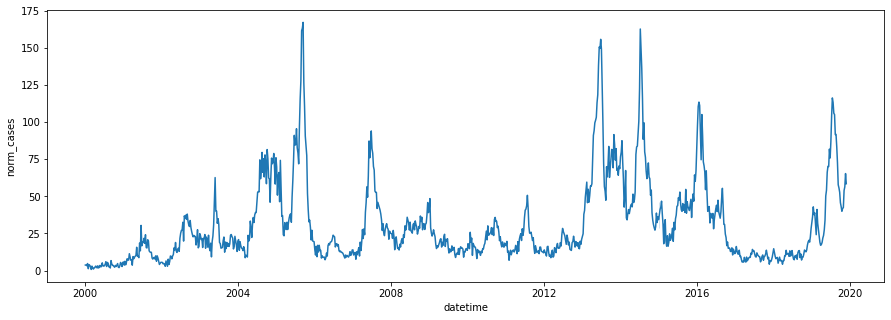

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data, kind='line', ax=ax)
plt.close()

#### Get subset of data

In [23]:
data_filter = (data['datetime'] >= '2008') & (data['datetime'] < '2014')

In [24]:
in_control_filter = (data['datetime'] >= '2008') & (data['datetime'] < '2013')

In [25]:
cutoff = '2013'

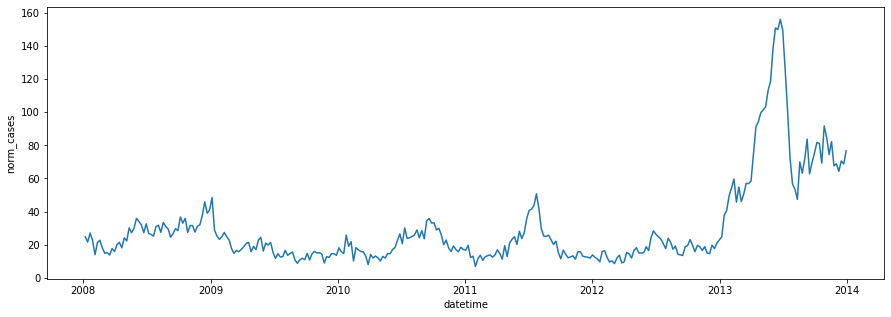

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data[data_filter], kind='line', ax=ax)
plt.close()

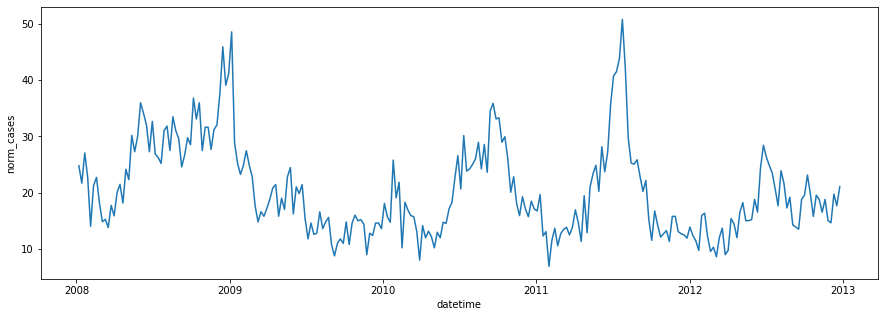

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='datetime', y='norm_cases', data=data[in_control_filter], kind='line', ax=ax)
plt.close()

#### Test for auto correlation

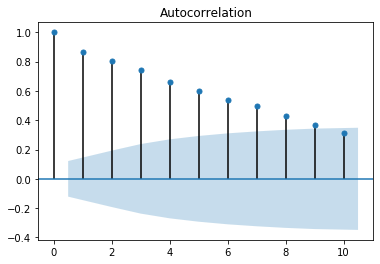

In [28]:
_ = plot_acf(data.loc[in_control_filter, 'norm_cases'], lags=10)

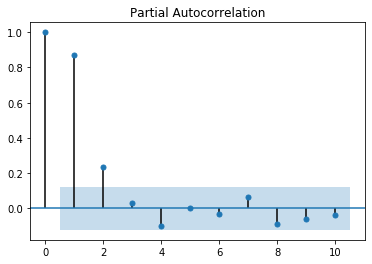

In [29]:
_ = plot_pacf(data.loc[in_control_filter, 'norm_cases'], lags=10)

In [30]:
st.ljungbox_(data.loc[in_control_filter, 'norm_cases'], print_extra=True)

Statistics=986.606, p=0.000
There is correlation up to lag 10 (reject H0)
[197.43414394 369.48377044 515.9545599  632.85131576 729.74917689
 806.83920595 872.68485848 922.46345303 959.52133211 986.60612552]
[7.58187803e-045 5.85623738e-081 1.66332053e-111 1.20150305e-135
 1.81277138e-155 5.12542157e-171 3.79640771e-184 8.05453373e-194
 9.19825259e-201 1.43540546e-205]


#### Hypothesis test (poisson)

In [31]:
sample_mean = data.loc[in_control_filter, 'norm_cases'].mean()
sample_variance = data.loc[in_control_filter, 'norm_cases'].var()

In [32]:
sample_mean

20.366154679619893

In [33]:
# Variance is much larger than mean
sample_variance

65.8941365860763

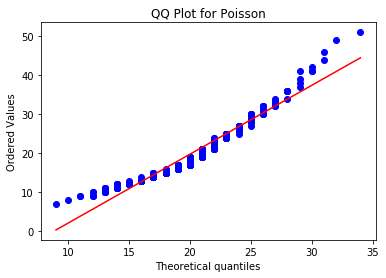

In [34]:
fig, ax = plt.subplots()
_ = stats.probplot(round(data.loc[in_control_filter, 'norm_cases']), dist=stats.poisson, sparams=(sample_mean, ), plot=ax)
_ = plt.title('QQ Plot for Poisson')

#### Use Chisq goodness of fit (poisson)

In [35]:
# round to whole numbers for discrete test
obs = round(data.loc[in_control_filter, 'norm_cases'])
obs_x = obs.sort_values().unique().tolist()

In [36]:
theoretical_freq = pd.Series(stats.poisson.pmf(obs_x, obs.mean()), index = obs_x)
obs_freq = obs.value_counts() / obs.value_counts().sum()

In [37]:
compare_df = pd.concat([theoretical_freq, obs_freq], axis=1)
compare_df.columns = ['theoretical_freq', 'obs_freq']

In [38]:
stats.chisquare(f_obs = compare_df.obs_freq, f_exp = compare_df.theoretical_freq)

Power_divergenceResult(statistic=3174.7720736979963, pvalue=0.0)

#### Hypothesis test (NBD)

In [39]:
# Estimate negative binomial parameters
NBD = NegativeBinomial(round(data.loc[in_control_filter, 'norm_cases']), 
                       np.ones(len(round(data.loc[in_control_filter, 'norm_cases']))), 
                       loglike_method='nb2')

results = NBD.fit()

Optimization terminated successfully.
         Current function value: 3.425464
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7


In [40]:
results.params

const    3.015535
alpha    0.096787
dtype: float64

In [41]:
def convert_nbd_params1(const, alpha):
    mu = np.exp(const)
    n = 1. / alpha
    p = n / (n + mu)
    return n, p

In [42]:
n, p = convert_nbd_params1(results.params[0], results.params[1])

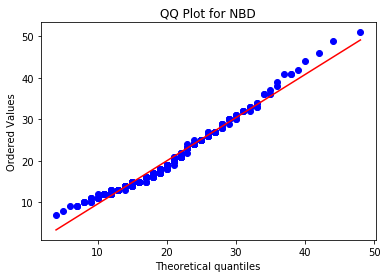

In [43]:
fig, ax = plt.subplots()
_ = stats.probplot(round(data.loc[in_control_filter, 'norm_cases']), dist=stats.nbinom, sparams=(n, p, ), plot=ax)
_ = plt.title('QQ Plot for NBD')

#### Use Chisq goodness of fit (NBD)

In [44]:
theoretical_freq = pd.Series(stats.nbinom.pmf(obs_x, n, p), index = obs_x)
obs_freq = obs.value_counts() / obs.value_counts().sum()

In [45]:
compare_df = pd.concat([theoretical_freq, obs_freq], axis=1)
compare_df.columns = ['theoretical_freq', 'obs_freq']

In [46]:
stats.chisquare(f_obs = compare_df.obs_freq, f_exp = compare_df.theoretical_freq)

Power_divergenceResult(statistic=0.2441049221016417, pvalue=1.0)

#### Use NBD control chart

In [47]:
ret = pd.DataFrame({
    'obs':data.loc[data_filter, 'norm_cases'].tolist(),
    'UCL':sample_mean + 3*np.sqrt(sample_variance),
    'Center':sample_mean,
    'LCL':sample_mean + 3*np.sqrt(sample_variance)
})

In [48]:
ret = pd.concat([data.loc[data_filter, 'datetime'].reset_index(drop=True), ret], axis=1)

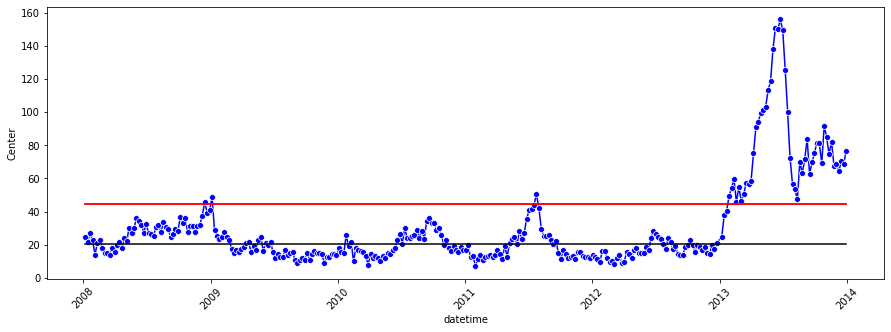

In [49]:
pf.plot_control_chart(
    data = ret,
    index = 'datetime',
    obs = 'obs',
    UCL = 'UCL',
    center = 'Center',
    LCL = 'LCL',
    all_dates=False,
    rot=45)

In [56]:
ret['datetime'][ret['obs'] > ret['UCL']][0:6]

49    2008-12-15
52    2009-01-05
185   2011-07-25
263   2013-01-28
264   2013-02-04
265   2013-02-11
Name: datetime, dtype: datetime64[ns]

#### Calculate moving range

In [52]:
MR = cp.calculate_MR(data.loc[in_control_filter, 'norm_cases'])
sigma = cp.estimate_sigma_from_MR(MR)

In [53]:
sigma**2

8.423021120174914

In [54]:
sample_variance

65.8941365860763